# Model comparison on antibiotic dataset

In [1]:
import numpy as np
import pandas as pd
import random

random.seed(42)

from matplotlib import pyplot as plt

from scipy.optimize import minimize
from sklearn.model_selection import LeaveOneOut

In [2]:
def briere1(T, Tmin=10.0, Tmax=50.0, c=1.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) + 0.5 * np.log(Tmax - T[cond]))
    return result

def briere2(T, Tmin=10.0, Tmax=50.0, c=1.0, b=2.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) +  np.log(Tmax - T[cond]) / b)
    return result

# Fully biologically interpretable parametrization of flexTPC model
def flexTPC(T, Tmin=10.0, Tmax=50.0, rmax=1.0, α=0.8, β=0.2):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    s = α * (1.0 - α) / β**2
    result[cond] = rmax * np.exp(s * (α * (np.log(T[cond] - Tmin) - np.log(α)) +
                                      (1 - α) * (np.log(Tmax - T[cond]) - np.log(1 - α) )
                                       - np.log(Tmax - Tmin)))
    return result

# Exponential product curve.
def expprodcurve(T, Tmin=10.0, Tmax=50.0, c=1.0, kI=0.1, kU=0.5):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * (1.0 - np.exp(-kI*(T[cond] - Tmin))) * (1.0 - np.exp(-kU*(Tmax - T[cond])))
    return result

# Kumaraswarmy distribution TPC.
def kumaraswarmy(T, Tmin=10.0, Tmax=50.0, c=1.0, a=5.0, b=5.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    τ = (T[cond] - Tmin) / (Tmax - Tmin)
    result[cond] = c * τ**(a - 1) * (1.0 - τ**a)**(b - 1)
    return result

In [3]:
def nloglik2(θ, Tdata, rdata, model=flexTPC):
    params, σ2 = θ[:-1], θ[-1]
    Tmin, Tmax = θ[:2]
    #outside = (Tdata < Tmin) | (Tdata > Tmax)
    n = len(rdata)
    return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata - model(Tdata, *params))**2 / σ2))
    
def AIC(nll, p):
    return 2 * nll + 2 * p 

def BIC(nll, n, p):
    return 2 * nll + p * np.log(n)

## E. coli antibiotics dataset

In [4]:
abcoli = pd.read_csv("ab_data.csv")
single = abcoli[(abcoli["drug2name"] == "WT")]
drugs = ['AMP',
 'CLI',
 'CPR',
 'ERY',
 'FOX',
 'GEN',
 'LVX',
 'NTR',
 'STR',
 'TET',
 'TMP',
 'TOB',
 'WT']

In [5]:
drugs

['AMP',
 'CLI',
 'CPR',
 'ERY',
 'FOX',
 'GEN',
 'LVX',
 'NTR',
 'STR',
 'TET',
 'TMP',
 'TOB',
 'WT']

In [6]:
single

,drug1name,drug2name,drug1num,drug2num,T,t,sample,OD
28,NTR,WT,8.0,13.0,37.0,24.0,1.0,0.6244
29,NTR,WT,8.0,13.0,37.0,24.0,2.0,0.6865
30,NTR,WT,8.0,13.0,37.0,24.0,3.0,0.7640
31,NTR,WT,8.0,13.0,37.0,24.0,4.0,0.7984
32,NTR,WT,8.0,13.0,22.0,24.0,1.0,0.0139
...,...,...,...,...,...,...,...,...
1927,TET,WT,10.0,13.0,44.0,24.0,4.0,0.3349
1928,TET,WT,10.0,13.0,30.0,24.0,1.0,0.3772
1929,TET,WT,10.0,13.0,30.0,24.0,2.0,0.3865
1930,TET,WT,10.0,13.0,30.0,24.0,3.0,0.3883


In [7]:
abdata = single.groupby(["drug1name", "T"], as_index=False).agg({'OD':'mean'})
#Set low values to zero

#abdata["OD"][abdata["OD"] < 0.02] = 0.0

In [8]:
abdata[abdata["OD"] < 0.0]

,drug1name,T,OD


In [9]:
abdata[abdata["drug1name"] == "AMP"]

,drug1name,T,OD
0,AMP,22.0,0.255500
1,AMP,25.0,0.399700
2,AMP,30.0,0.717800
3,AMP,37.0,0.713775
4,AMP,41.0,0.625300
5,AMP,44.0,0.001950
6,AMP,46.0,0.002450


In [10]:
def nloglikab(θ, Tdata, rdata, model=flexTPC):
    params, σ2 = θ[:-1], θ[-1]
    Tmin, Tmax = θ[:2]
    return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata 
                                                    - model(Tdata, *params))**2 / σ2))

In [11]:
#initial_mb["GEN"] = [20.0, 46.5, 0.5, 0.7, 2.0, 0.005]
#initial_mb["STR"] = [20.0, 46.5, 0.5, 0.7, 2.0, 0.005]
#initial_mb["TOB"] = [20.0, 46.5, 0.5, 0.7, 2.0, 0.005]
#initial_mb["ERY"] = [20.0, 46.5, 0.5, 0.7, 4.0, 0.005]
#initial_mb["AMP"] = [15.0, 46.5, 0.7, 0.7, 2.0, 0.005]

initial_b1 = {drug:[20.0, 46.5, 3e-4, 0.005] for drug in drugs}
initial_b2 = {drug:[20.0, 46.5, 3e-4, 2.0, 0.005] for drug in drugs}
initial_flex = {drug:[20.0, 46.5, 0.7, 0.7, 0.2, 0.005] for drug in drugs}
initial_epc = {drug:[20.0, 46.5, 1.0, 0.05, 0.4, 0.005] for drug in drugs}
initial_kum = {drug:[20.0, 46.5, 2.0, 3, 2, 0.005] for drug in drugs}

In [12]:
loo = LeaveOneOut()
loo.get_n_splits(abdata["T"][abdata["drug1name"] == "WT"])

7

In [13]:
initial_flex

{'AMP': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'CLI': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'CPR': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'ERY': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'FOX': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'GEN': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'LVX': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'NTR': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'STR': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'TET': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'TMP': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'TOB': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'WT': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005]}

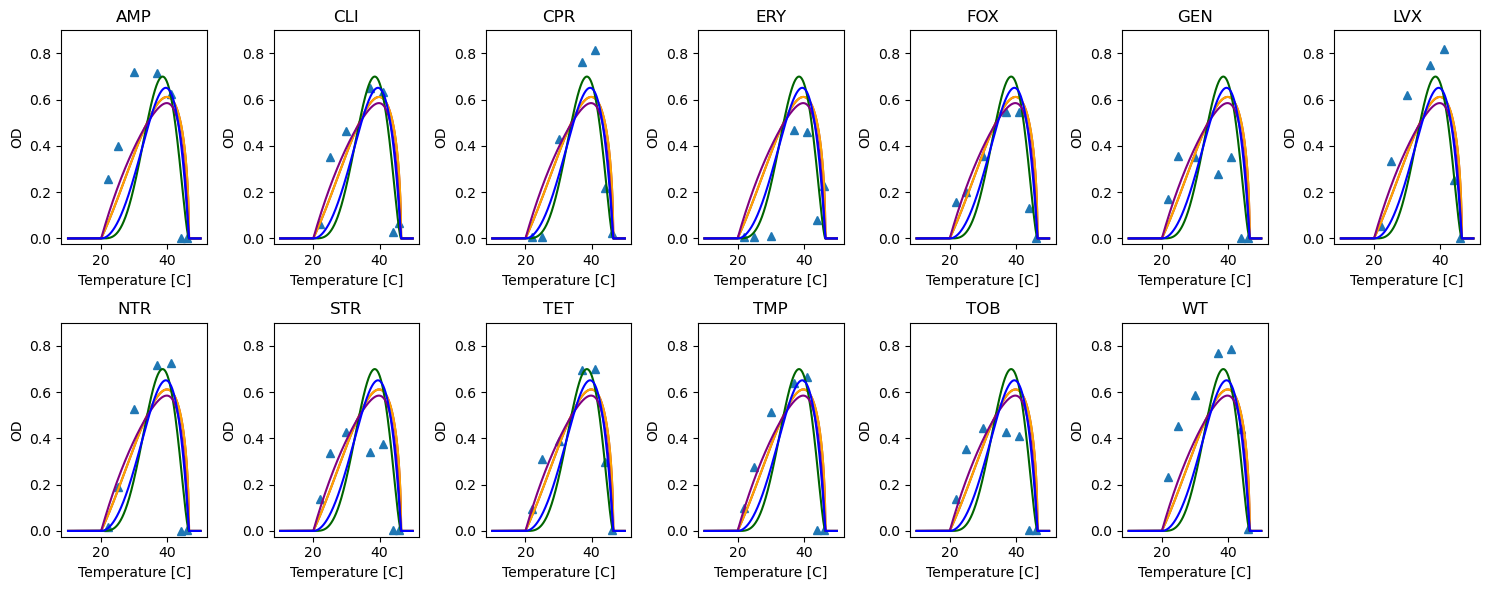

In [14]:
T = np.arange(10, 50, 0.001)
plt.figure(figsize=(15, 6))


for i, drug in enumerate(drugs):
    subset = abdata[abdata["drug1name"] == drug]
    
    plt.subplot(2, 7, i+1)
    # Plot datapoints.
    Tdata = subset["T"]
    rdata = subset["OD"]

    plt.plot(Tdata, rdata, '^')
    
    # Plot initial parameters curves by Briere.
    par = initial_b1[drug]    
    plt.plot(T, briere1(T, *par[:-1]), color="firebrick")
    
    par = initial_b2[drug]
    plt.plot(T, briere2(T, *par[:-1]), color="orange")
    
    par = initial_flex[drug]
    plt.plot(T, flexTPC(T, *par[:-1]), color="darkgreen")

    par = initial_epc[drug]
    plt.plot(T, expprodcurve(T, *par[:-1]), color="purple")

    par = initial_kum[drug]
    plt.plot(T, kumaraswarmy(T, *par[:-1]), color="blue")
    
    plt.ylim(-0.025, 0.9)
    plt.xlabel("Temperature [C]")
    plt.ylabel("OD", fontsize=10)
    plt.title(drug)
plt.tight_layout()

In [15]:
# LOOCV

params = {"flexTPC":{}, "b1":{}, "b2":{}, "epc":{}, "kum":{}}
models = ["b1", "b2", "flexTPC", "epc", "kum"]
loocv_nll = {model:{drug:[] for drug in drugs } for model in models}

method = "Nelder-Mead"
for i, drug in enumerate(drugs):
    subset = abdata[abdata["drug1name"] == drug]
    Tdata = np.array(subset["T"])
    rdata = np.array(subset["OD"])
    
    print(drug)
    print("numsplits:", loo.get_n_splits(Tdata))
    
    for train, test in loo.split(Tdata):
        T_train, r_train = Tdata[train], rdata[train]
        T_test, r_test = Tdata[test], rdata[test]
    

        params["b1"][drug] = minimize(nloglikab, initial_b1[drug],
                           bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 10.0),  
                                    (0, 0.01)],
                      args=(Tdata, rdata, briere1), options={"maxiter":100000}, method=method)
        θ = params["b1"][drug]["x"]
        loocv_nll["b1"][drug].append(nloglikab(θ, T_test, r_test, model=briere1))

        params["b2"][drug] = minimize(nloglikab, initial_b2[drug],
                            bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 10.0),
                                    (1.0, 20.0),
                                    (0, 0.01)],
                      args=(Tdata, rdata, briere2), options={"maxiter":100000}, method=method)
        θ = params["b2"][drug]["x"]
        loocv_nll["b2"][drug].append(nloglikab(θ, T_test, r_test, model=briere2))

        
        params["flexTPC"][drug] = minimize(nloglikab, initial_flex[drug], #Check nloglikab vs nloglok
                            bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 1.0), 
                                    (0.1, 0.95), 
                                    (0.0, 2.0), 
                                    (0, 0.01)],
                      args=(Tdata, rdata), options={"maxiter":100000}, method=method)
        θ = params["flexTPC"][drug]["x"]
        loocv_nll["flexTPC"][drug].append(nloglikab(θ, T_test, r_test, model=flexTPC))

        params["epc"][drug] = minimize(nloglikab, initial_epc[drug],
                                bounds=[(0.0, 20.0), 
                                        (30.0, 60.0), 
                                        (0.0, np.inf), 
                                        (0.0, np.inf), 
                                        (0.0, np.inf), 
                                        (0, 1.0)],
                          args=(Tdata, rdata, expprodcurve), options={"maxiter":100000}, method=method)
        θ = params["epc"][drug]["x"]
        loocv_nll["epc"][drug].append(nloglikab(θ, T_test, r_test, model=expprodcurve))

        params["kum"][drug] = minimize(nloglikab, initial_kum[drug],
                                        bounds=[(0.0, 20.0), 
                                                (30.0, 60.0),
                                                (0.0, np.inf), 
                                                (1.0, np.inf), 
                                                (1.0, np.inf), 
                                                (0, 1.0)],
                                  args=(Tdata, rdata, kumaraswarmy), options={"maxiter":100000}, method=method)
        θ = params["kum"][drug]["x"]
        loocv_nll["kum"][drug].append(nloglikab(θ, T_test, r_test, model=kumaraswarmy))

AMP
numsplits: 7
CLI
numsplits: 7
CPR
numsplits: 7
ERY
numsplits: 7
FOX
numsplits: 7


/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90204/1310441239.py:4: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90204/1310441239.py:4: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90204/1310441239.py:4: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata


GEN
numsplits: 7
LVX
numsplits: 7
NTR
numsplits: 7
STR
numsplits: 7
TET
numsplits: 7
TMP
numsplits: 7
TOB
numsplits: 7
WT
numsplits: 7


In [16]:
params = {"flexTPC":{}, "b1":{}, "b2":{}, "epc":{}, "kum":{}}
models = ["b1", "b2", "flexTPC", "epc", "kum"]
method = "Nelder-Mead"
for i, drug in enumerate(drugs):
    subset = abdata[abdata["drug1name"] == drug]
    Tdata = np.array(subset["T"])
    rdata = np.array(subset["OD"])    

    params["b1"][drug] = minimize(nloglikab, initial_b1[drug],
                           bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 10.0),  
                                    (0, 0.01)],
                      args=(Tdata, rdata, briere1), options={"maxiter":100000}, method=method)
    
    params["b2"][drug] = minimize(nloglikab, initial_b2[drug],
                            bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 10.0),
                                    (1.0, 20.0),
                                    (0, 0.01)],
                      args=(Tdata, rdata, briere2), options={"maxiter":100000}, method=method)
    params["flexTPC"][drug] = minimize(nloglikab, initial_flex[drug], #nloglikab vs nloglok
                            bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 1.0), 
                                    (0.1, 0.95), 
                                    (0.0, 2.0), 
                                    (0, 0.01)],
                      args=(Tdata, rdata), options={"maxiter":100000}, method=method)
    params["epc"][drug] = minimize(nloglikab, initial_epc[drug],
                                bounds=[(0.0, 20.0), 
                                        (30.0, 60.0), 
                                        (0.0, np.inf), 
                                        (0.0, np.inf), 
                                        (0.0, np.inf), 
                                        (0, 1.0)],
                          args=(Tdata, rdata, expprodcurve), options={"maxiter":100000}, method=method)
    params["kum"][drug] = minimize(nloglikab, initial_kum[drug],
                                        bounds=[(0.0, 20.0), 
                                                (30.0, 60.0),
                                                (0.0, np.inf), 
                                                (1.0, np.inf), 
                                                (1.0, np.inf), 
                                                (0, 1.0)],
                                  args=(Tdata, rdata, kumaraswarmy), options={"maxiter":100000}, method=method)

/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90204/1310441239.py:4: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90204/1310441239.py:4: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90204/1310441239.py:4: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata


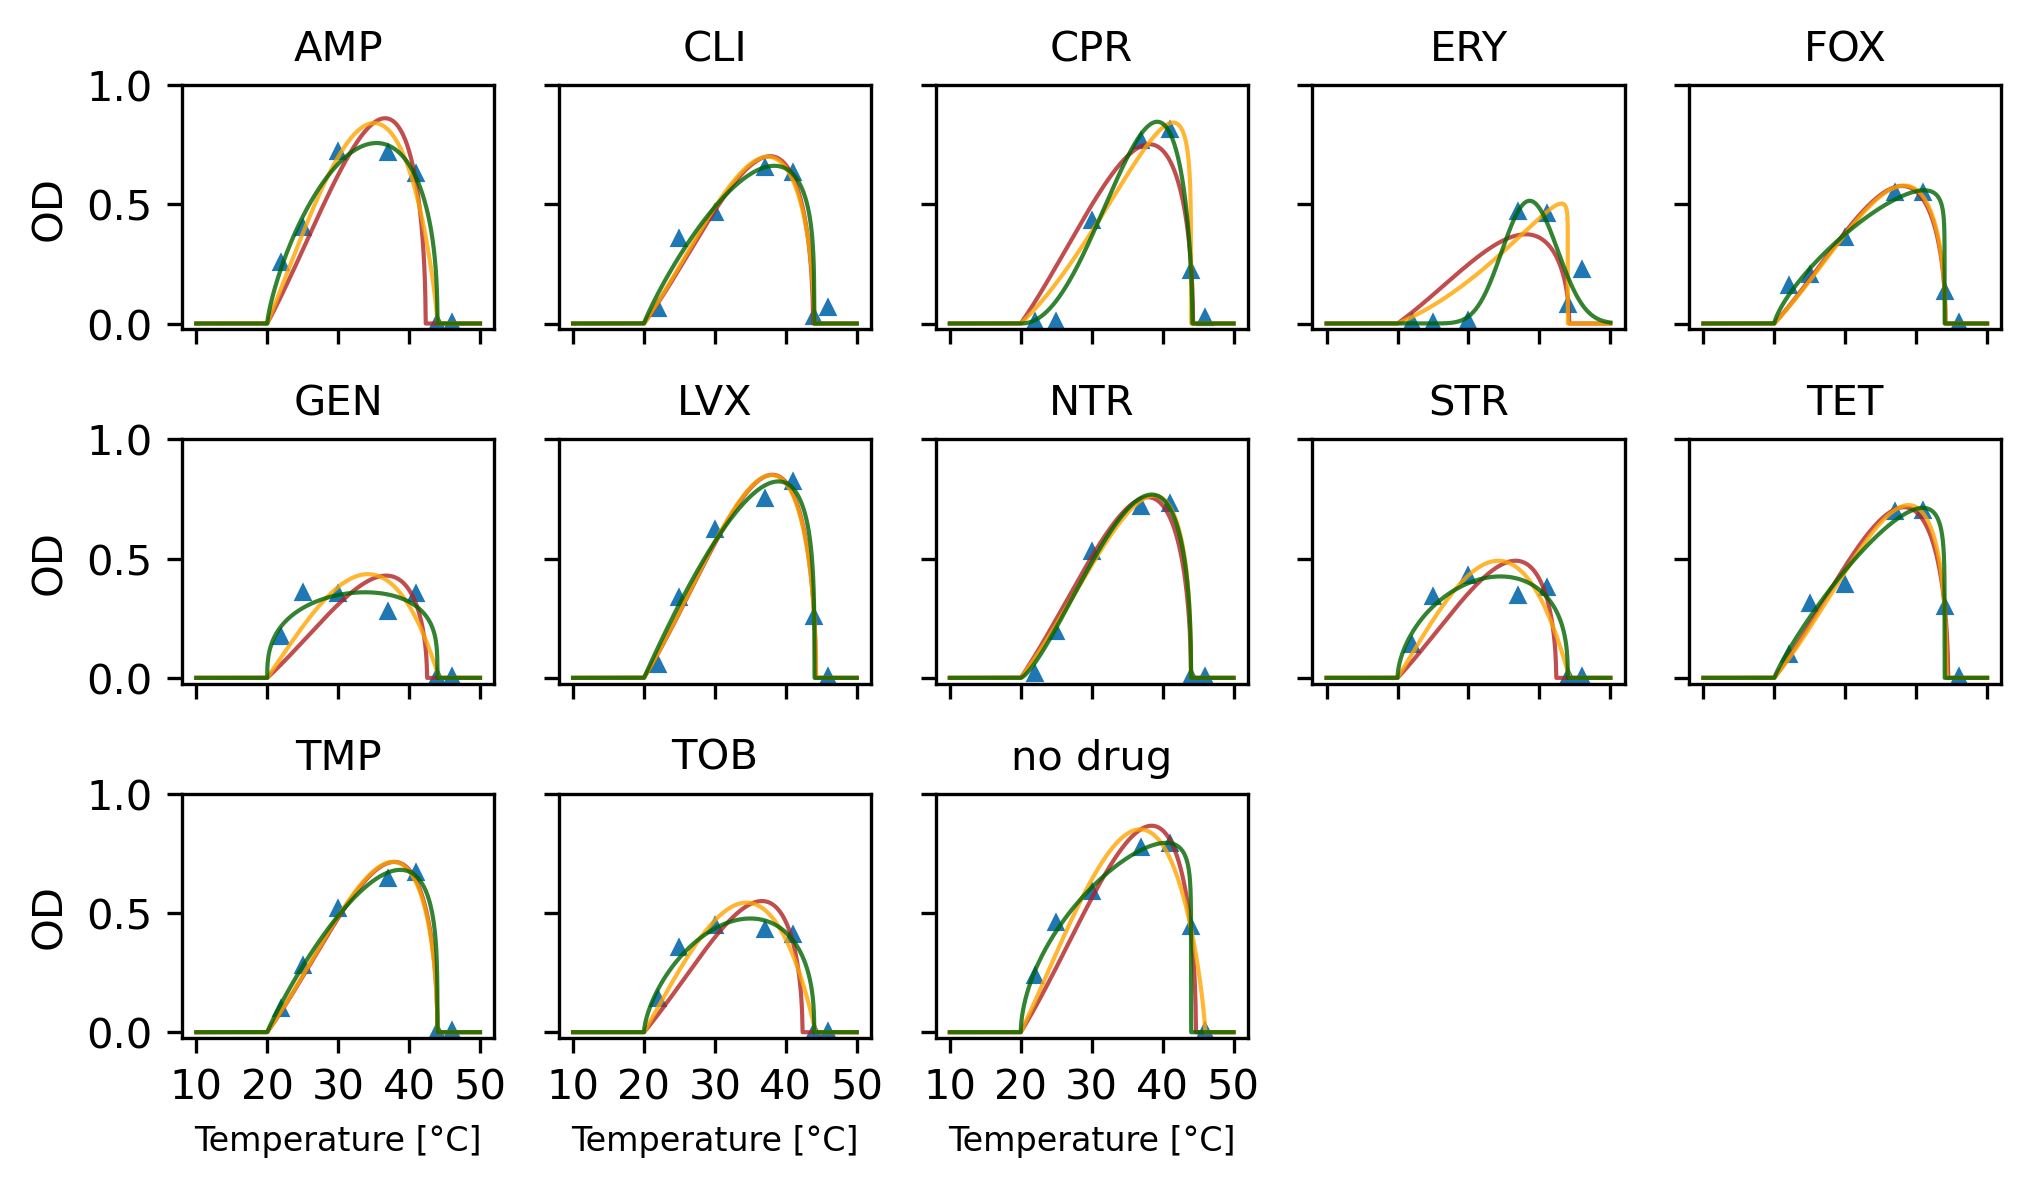

In [17]:
T = np.arange(10, 50, 0.001)

fig, axarr = plt.subplots(3, 5, figsize=(6.81102, 4), dpi=300, sharex=True, sharey=True)

plt.rcParams.update({'font.size': 8})

for i, drug in enumerate(drugs):
    ax = axarr[i // 5, i % 5]
    subset = abdata[abdata["drug1name"] == drug]

    ax.set_xticks([10, 20, 30, 40, 50])
    ax.set_yticks([0, 0.5, 1])


    #plt.subplot(3, 5, i+1)
    # Plot datapoints.
    Tdata = subset["T"]
    rdata = subset["OD"]

    ax.plot(Tdata, rdata, '^', markersize=3)
    
    # Plot fitted curves by Briere.
    par = params["b1"][drug]["x"]
    ax.plot(T, briere1(T, *par[:-1]), color="firebrick", linewidth=1, alpha=0.8)
    
    par = params["b2"][drug]["x"]
    ax.plot(T, briere2(T, *par[:-1]), color="orange", linewidth=1, alpha=0.8)
    
             
    par = params["flexTPC"][drug]["x"]
    ax.plot(T, flexTPC(T, *par[:-1]), color="darkgreen", linewidth=1, alpha=0.8)
    

    #par = params["epc"][drug]["x"]
    #ax.plot(T, expprodcurve(T, *par[:-1]), color="purple", linewidth=1, alpha=0.8)

    #par = params["kum"][drug]["x"]
    #ax.plot(T, kumaraswarmy(T, *par[:-1]), color="blue", linewidth=1, alpha=0.8)
    
    ax.set_ylim(-0.025, 1.0)

    if drug != 'WT':
        ax.set_title(drug, fontsize=10)
    else:
        ax.set_title('no drug', fontsize=10)
    if drug in ("TMP", "TOB", "WT"):
        ax.set_xlabel("Temperature [°C]", fontsize=8)
    if drug in ("AMP", "GEN", "TMP"):
        ax.set_ylabel("OD", fontsize=10)
        
axarr[-1, -1].axis("off")
axarr[-1, -2].axis("off")


#ERY
#rect = plt.Rectangle(
#        # (lower-left corner), width, height
#        (0.63, 0.69), 0.18, 0.29, fill=False, color="k", lw=1.5, 
#        zorder=1000, transform=fig.transFigure, figure=fig
#    )

#GEN
#rect2 = plt.Rectangle(
#        # (lower-left corner), width, height
#        (0.04, 0.4), 0.22, 0.29, fill=False, color="k", lw=1.5, 
#        zorder=1000, transform=fig.transFigure, figure=fig
#    )

#fig.patches.extend([rect, rect2])
plt.tight_layout()

plt.savefig("abcoli.svg")
plt.savefig("abcoli.pdf")
plt.savefig("abcoli.png")

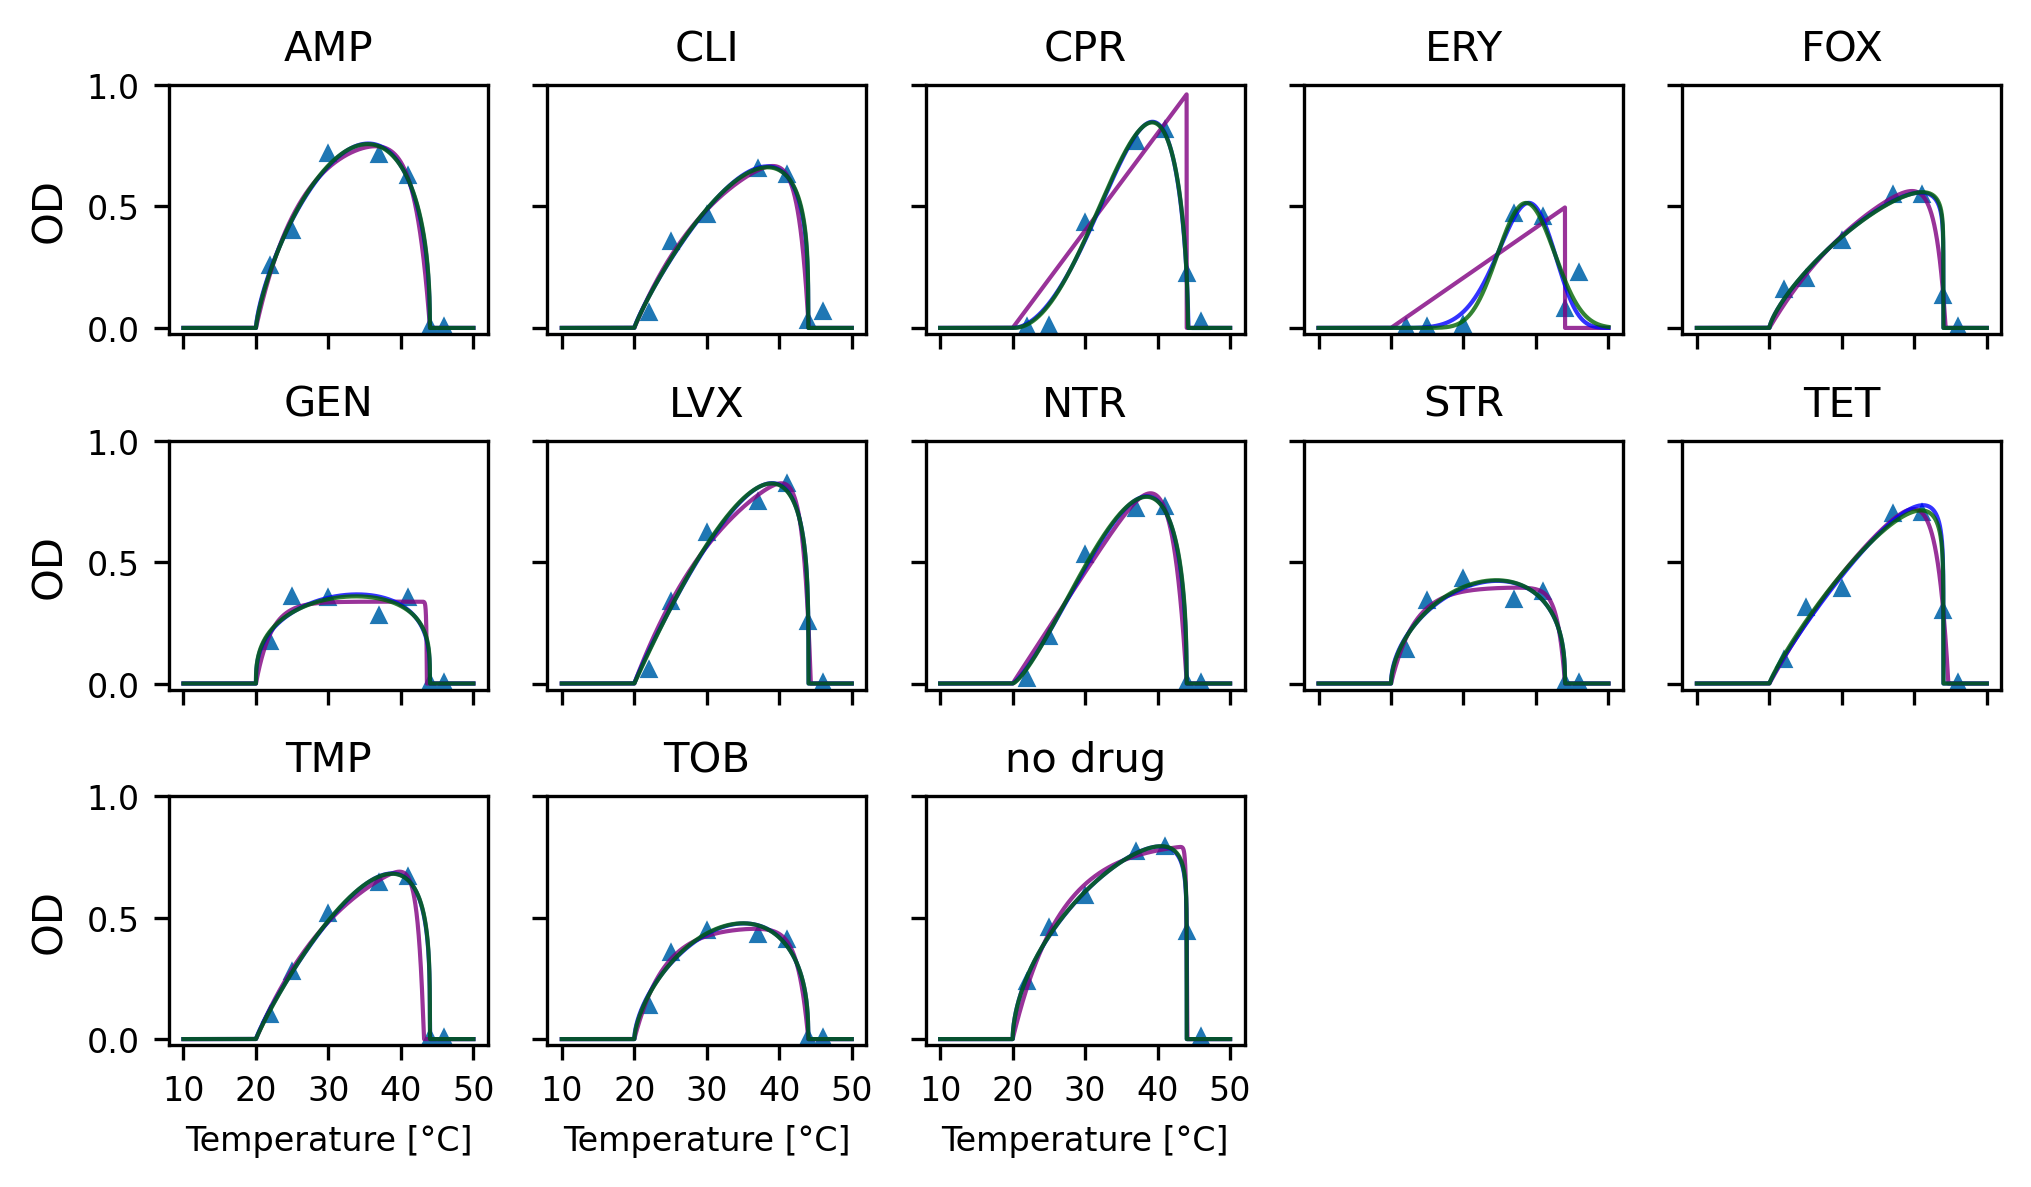

In [18]:
T = np.arange(10, 50, 0.001)

fig, axarr = plt.subplots(3, 5, figsize=(6.81102, 4), dpi=300, sharex=True, sharey=True)

plt.rcParams.update({'font.size': 8})

for i, drug in enumerate(drugs):
    ax = axarr[i // 5, i % 5]
    subset = abdata[abdata["drug1name"] == drug]

    ax.set_xticks([10, 20, 30, 40, 50])
    ax.set_yticks([0, 0.5, 1])


    #plt.subplot(3, 5, i+1)
    # Plot datapoints.
    Tdata = subset["T"]
    rdata = subset["OD"]

    ax.plot(Tdata, rdata, '^', markersize=3)

             
    
    

    par = params["epc"][drug]["x"]
    ax.plot(T, expprodcurve(T, *par[:-1]), color="purple", linewidth=1, alpha=0.8)

    par = params["kum"][drug]["x"]
    ax.plot(T, kumaraswarmy(T, *par[:-1]), color="blue", linewidth=1, alpha=0.8)

    par = params["flexTPC"][drug]["x"]
    ax.plot(T, flexTPC(T, *par[:-1]), color="darkgreen", linewidth=1, alpha=0.8)
    
    ax.set_ylim(-0.025, 1.0)

    if drug != 'WT':
        ax.set_title(drug, fontsize=10)
    else:
        ax.set_title('no drug', fontsize=10)
    if drug in ("TMP", "TOB", "WT"):
        ax.set_xlabel("Temperature [°C]", fontsize=8)
    if drug in ("AMP", "GEN", "TMP"):
        ax.set_ylabel("OD", fontsize=10)
        
axarr[-1, -1].axis("off")
axarr[-1, -2].axis("off")


#ERY
#rect = plt.Rectangle(
#        # (lower-left corner), width, height
#        (0.63, 0.69), 0.18, 0.29, fill=False, color="k", lw=1.5, 
#        zorder=1000, transform=fig.transFigure, figure=fig
#    )

#GEN
#rect2 = plt.Rectangle(
#        # (lower-left corner), width, height
#        (0.04, 0.4), 0.22, 0.29, fill=False, color="k", lw=1.5, 
#        zorder=1000, transform=fig.transFigure, figure=fig
#    )

#fig.patches.extend([rect, rect2])
plt.tight_layout()

plt.savefig("abcoli_pc_kum.svg")
plt.savefig("abcoli_pc_kum.pdf")
plt.savefig("abcoli_pc_kum.png")

In [19]:
n_params = {'b1':4, 'b2':5, 'flexTPC':6, 'epc':6, 'kum':6} # Includes standard deviation.
param_matrix = {model:np.zeros((13, n_params[model])) for model in models}

for model in models:
    for i, drug in enumerate(drugs):
        param_matrix[model][i, ] = params[model][drug]["x"]

colnames = {'b1':['Tmin', 'Tmax', 'c', 'sigma2'],
            'b2':['Tmin', 'Tmax', 'c', 'm', 'sigma2'],
            'flexTPC':['Tmin', 'Tmax', 'rmax', 'alpha', 'beta', 'sigma2'],
           'epc':['Tmin', 'Tmax', 'c', 'kI', 'kU', 'sigma2'],
           'kum':['Tmin', 'Tmax', 'c', 'a', 'b', 'sigma2']}

param_df = {model:pd.DataFrame(param_matrix[model], columns=colnames[model]) for model in models}
for model in models:
    param_df[model]['drug'] = drugs
    param_df[model] = param_df[model][['drug'] + colnames[model]]
    param_df[model].to_csv(f'abcoli_params_{model}.csv', index=False)

In [20]:
param_df['epc']

,drug,Tmin,Tmax,c,kI,kU,sigma2
0,AMP,20.0,44.007843,0.824156,1.614674e-01,0.493304,0.001229
1,CLI,20.0,44.054805,0.866008,8.242660e-02,0.713136,0.001949
2,CPR,20.0,44.000001,71240.939870,5.623456e-07,180349.336808,0.007429
3,ERY,20.0,44.000002,138202.531337,1.494974e-07,95836.460775,0.016318
4,FOX,20.0,44.322608,0.850540,5.915439e-02,0.712125,0.000682
5,GEN,20.0,43.586791,0.336935,4.717883e-01,13.322271,0.001133
6,LVX,20.0,44.356000,1.096169,7.229880e-02,0.930030,0.001773
7,NTR,20.0,44.005670,1665.495450,2.757200e-05,0.455426,0.001853
8,STR,20.0,44.010421,0.397158,3.059134e-01,0.961540,0.001156
9,TET,20.0,44.694587,1.443680,3.744536e-02,0.612516,0.001204


In [33]:
nll = np.zeros((len(drugs), len(models)))
aic = np.zeros((len(drugs), len(models)))
bic = np.zeros((len(drugs), len(models)))
loo_nll = np.zeros((len(drugs), len(models)))

p = [4, 5, 6, 6, 6] # Number of parameters.
n = 7 # Number of datapoints.

for i, d in enumerate(drugs):
    for j, m in enumerate(models): 
        nll[i, j] = params[m][d]["fun"]
        aic[i, j] = AIC(nll[i, j], p[j])
        bic[i, j] = BIC(nll[i, j], n, p[j])
        loo_nll[i, j] = np.mean(loocv_nll[m][d])

In [34]:
drugs

['AMP',
 'CLI',
 'CPR',
 'ERY',
 'FOX',
 'GEN',
 'LVX',
 'NTR',
 'STR',
 'TET',
 'TMP',
 'TOB',
 'WT']

In [35]:
for drug in drugs:
    print(drug, np.round(params["flexTPC"][drug]["x"], 3) )

AMP [2.00e+01 4.40e+01 7.57e-01 6.42e-01 4.38e-01 1.00e-03]
CLI [2.00e+01 4.40e+01 6.61e-01 7.65e-01 3.87e-01 2.00e-03]
CPR [2.0000e+01 4.4195e+01 8.4600e-01 7.9500e-01 2.4300e-01 2.0000e-03]
ERY [2.00e+01 6.00e+01 5.15e-01 4.66e-01 9.70e-02 5.00e-03]
FOX [2.00e+01 4.40e+01 5.59e-01 8.80e-01 3.52e-01 1.00e-03]
GEN [2.00e+01 4.40e+01 3.59e-01 5.75e-01 6.18e-01 2.00e-03]
LVX [2.0000e+01 4.4026e+01 8.2400e-01 7.8800e-01 3.6300e-01 2.0000e-03]
NTR [2.00e+01 4.40e+01 7.69e-01 7.69e-01 3.14e-01 1.00e-03]
STR [2.00e+01 4.40e+01 4.25e-01 6.04e-01 5.01e-01 2.00e-03]
TET [2.0000e+01 4.4001e+01 7.1300e-01 8.7200e-01 3.3100e-01 1.0000e-03]
TMP [20.    44.     0.681  0.782  0.377  0.   ]
TOB [2.00e+01 4.40e+01 4.77e-01 6.24e-01 4.73e-01 1.00e-03]
WT [20.    44.003  0.794  0.853  0.437  0.   ]


In [36]:
dfAIC = pd.DataFrame(np.round(aic, 2), columns=models, index=drugs)
dfBIC = pd.DataFrame(np.round(bic, 2), columns=models, index=drugs)
dfLOOCV = pd.DataFrame(np.round(loo_nll, 2), columns=models, index=drugs)

In [37]:
dfAIC

,b1,b2,flexTPC,epc,kum
AMP,-5.56,-8.64,-17.12,-15.04,-16.95
CLI,-11.98,-10.51,-11.38,-11.82,-11.20
CPR,-2.92,-7.16,-11.75,-2.45,-11.03
ERY,3.28,0.25,-4.95,3.06,-3.54
FOX,-18.14,-16.31,-21.11,-19.17,-21.33
GEN,-3.16,-3.96,-11.56,-15.61,-5.99
LVX,-12.93,-10.96,-12.43,-12.48,-11.90
NTR,-16.03,-16.47,-17.42,-12.17,-16.31
STR,-5.39,-7.42,-12.87,-15.47,-12.54
TET,-15.07,-13.83,-14.88,-15.19,-10.33


In [38]:
dfBIC

,b1,b2,flexTPC,epc,kum
AMP,-5.78,-8.91,-17.45,-15.37,-17.27
CLI,-12.19,-10.78,-11.70,-12.14,-11.52
CPR,-3.14,-7.43,-12.07,-2.77,-11.35
ERY,3.07,-0.02,-5.27,2.73,-3.87
FOX,-18.35,-16.58,-21.43,-19.49,-21.66
GEN,-3.38,-4.23,-11.88,-15.94,-6.31
LVX,-13.15,-11.23,-12.75,-12.81,-12.22
NTR,-16.25,-16.74,-17.74,-12.49,-16.64
STR,-5.61,-7.69,-13.19,-15.80,-12.87
TET,-15.28,-14.10,-15.20,-15.51,-10.65


In [44]:
dfLOOCV

,b1,b2,flexTPC,epc,kum
AMP,-0.97,-1.33,-2.08,-1.93,-2.07
CLI,-1.43,-1.47,-1.67,-1.70,-1.66
CPR,-0.78,-1.23,-1.70,-1.03,-1.64
ERY,-0.34,-0.70,-1.21,-0.64,-1.11
FOX,-1.87,-1.88,-2.36,-2.23,-2.38
GEN,-0.80,-1.00,-1.68,-1.97,-1.28
LVX,-1.50,-1.50,-1.74,-1.75,-1.71
NTR,-1.72,-1.89,-2.10,-1.73,-2.02
STR,-0.96,-1.24,-1.78,-1.96,-1.75
TET,-1.65,-1.70,-1.92,-1.94,-1.59


In [40]:
def get_delta(df):
    '''
    Turns results into difference relative to best model.
    '''
    best = np.min(df, axis=1) 
    return(df.subtract(np.min(df, axis=1), axis=0))

In [45]:
get_delta(dfAIC)

,b1,b2,flexTPC,epc,kum
AMP,11.56,8.48,0.00,2.08,0.17
CLI,0.00,1.47,0.60,0.16,0.78
CPR,8.83,4.59,0.00,9.30,0.72
ERY,8.23,5.20,0.00,8.01,1.41
FOX,3.19,5.02,0.22,2.16,0.00
GEN,12.45,11.65,4.05,0.00,9.62
LVX,0.00,1.97,0.50,0.45,1.03
NTR,1.39,0.95,0.00,5.25,1.11
STR,10.08,8.05,2.60,0.00,2.93
TET,0.12,1.36,0.31,0.00,4.86


In [46]:
get_delta(dfBIC)

,b1,b2,flexTPC,epc,kum
AMP,11.67,8.54,0.00,2.08,0.18
CLI,0.00,1.41,0.49,0.05,0.67
CPR,8.93,4.64,0.00,9.30,0.72
ERY,8.34,5.25,0.00,8.00,1.40
FOX,3.31,5.08,0.23,2.17,0.00
GEN,12.56,11.71,4.06,0.00,9.63
LVX,0.00,1.92,0.40,0.34,0.93
NTR,1.49,1.00,0.00,5.25,1.10
STR,10.19,8.11,2.61,0.00,2.93
TET,0.23,1.41,0.31,0.00,4.86


In [47]:
get_delta(dfLOOCV)

,b1,b2,flexTPC,epc,kum
AMP,1.11,0.75,0.00,0.15,0.01
CLI,0.27,0.23,0.03,0.00,0.04
CPR,0.92,0.47,0.00,0.67,0.06
ERY,0.87,0.51,0.00,0.57,0.10
FOX,0.51,0.50,0.02,0.15,0.00
GEN,1.17,0.97,0.29,0.00,0.69
LVX,0.25,0.25,0.01,0.00,0.04
NTR,0.38,0.21,0.00,0.37,0.08
STR,1.00,0.72,0.18,0.00,0.21
TET,0.29,0.24,0.02,0.00,0.35


In [32]:
get_delta(dfLOOCV[['b1', 'b2', 'flexTPC']])

,b1,b2,flexTPC
AMP,7.78,5.24,0.0
CLI,1.70,1.43,0.0
CPR,6.41,3.29,0.0
ERY,6.11,3.60,0.0
FOX,3.48,3.39,0.0
GEN,6.20,4.80,0.0
LVX,1.74,1.73,0.0
NTR,2.69,1.48,0.0
STR,5.74,3.73,0.0
TET,1.91,1.52,0.0


In [62]:
np.mean(get_delta(dfLOOCV), axis=0)

b1         5.630769
b2         4.307692
flexTPC    0.430000
epc        1.205385
kum        1.044615
dtype: float64

In [65]:
pd.DataFrame({'LOOCV':np.mean(get_delta(dfLOOCV), axis=0)})

,LOOCV
b1,5.630769
b2,4.307692
flexTPC,0.430000
epc,1.205385
kum,1.044615
